#  Patient Admission Scheduling - G09

## Problem Formulation


Given a hospital with multiple departments, each containing rooms and beds, the challenge is to optimize the management of patients and bed availability.
The goal is to efficiently assign a bed for each night a patient needs to stay in the hospital, considering the constraints of allocating beds to rooms and rooms to departments.

## Project Goal

The goal of the project is to develop an intelligent agent, documenting the design and implementation steps.

### Team Members
- 18851 Luís Gonçalves Oliveira
- 16443 Francisco Moreira Rebelo
- 21990 Allan Sales Aleluia


## Agent

### PEAS - Agent Structure

PEAS is a conceptual framework used in Artificial Intelligence to describe an agent system. The acronym PEAS stands for:

- **Performance Measure:** Refers to criteria that define the success of the agent in a specific task. These measures are used to evaluate how well the agent is performing its actions in the environment.

- **Environment:** Represents the context or scenario in which the agent operates. It may include all elements that affect or are affected by the agent, such as physical objects, other agents, external conditions, etc.

- **Actuators:** Are the means by which the agent brings about changes in the environment. These can be motors, communication devices, or any other means by which the agent can influence its surroundings.

- **Sensors:** Are the means by which the agent perceives its environment. Sensors provide information to the agent about the current state of the environment, enabling the agent to make informed decisions.

### Example of PEAS Application:

| **AGENT TYPE**      | **Performance Measure**                      | **Environment**                          | **Actuators**           | **Sensors** |
|:-------------------:|:-------------------------------------------:|:---------------------------------------:|:-----------------------:|:------------:|
| Hospital Scheduling | Efficient bed distribution; Minimize scheduling errors | Hospital area, including wards and surgery rooms | Automated scheduling system in Python | Bed occupancy sensors, information about available doctors and nurses |


### Task Environment for Hospital Scheduling

The task environment for the hospital scheduling agent is characterized as follows:

- **Fully-observable:** The agent has complete visibility into the current state of the hospital, including bed occupancy, availability of medical staff, and scheduling information.

- **Single-agent:** The scheduling decisions are made by a single agent, specifically the hospital scheduling system.

- **Deterministic:** The outcome of scheduling actions is predictable; scheduling decisions directly influence the subsequent state of bed occupancy and medical staff availability.

- **Sequential:** Scheduling decisions made in the current state affect future states; for example, assigning a bed and schedule to one patient may impact the availability for another patient.

- **Dynamic:** The environment is dynamic, as bed occupancy and medical staff availability can change over time due to patient admissions, discharges, and staff schedules.

- **Discrete:** The scheduling system operates within a discrete framework, with a finite number of beds, medical staff, and scheduling slots.

- **Known:** The outcomes of scheduling actions are known to the system; the impact of assigning a bed or schedule is understood.

This task environment outlines the key characteristics and dynamics relevant to the hospital scheduling agent's decision-making process.



### AIMA Code Files Used

The team incorporated the following files from the AIMA code:

- `csp.py`
- `utils.py`
- `search.py`

## Variables

**Beds:** Represents a list of available beds in the hospital, denoted by bed1 to bed8. It is created using a list comprehension to generate bed names with numerical suffixes ranging from 1 to 8.

**Patients:** Represents a list of patients who need scheduling and bed assignments in the hospital. It is created using a list comprehension to generate patient names with numerical suffixes ranging from 1 to the total number of patients (len(patients_data) + 1).

**Bed_Rooms:** A dictionary that maps each bed to its corresponding room number. This information is extracted from the dataset and used to determine the room assignment for each patient.

**Room_Departments:** A dictionary providing information about the departments associated with each room. This information is crucial for filtering bed choices based on departmental compatibility between patients and rooms.

## Domains

So, for each patient, the domain is initially set to be all available beds (1 through 8). As the code progresses and constraints are applied, certain beds are eliminated from the domain based on the patient's department, telemetry requirements, and oxygen requirements.

For example, when the code iterates through patients and room information to apply constraints, it selectively removes beds from the patient's domain based on compatibility with the room's properties and the patient's requirements. The goal is to narrow down the possible bed assignments for each patient, and the final solution is found using the constraint satisfaction solver.


## Input Data

We will use the dataset provided by the professor 'dataset.txt' by using a parser to read the .txt file and input the relevant data into de program.
This parser is in a separate file 'dataset_parser.py' and is under a function called 'dataset_parser()'.

In [ ]:
def dataset_parser(dataset):
    bed_rooms = {}
    room_departments = {}
    patients_data = {}

    lines = dataset.strip().split('\n')
    current_section = None

    for line in lines:
        words = line.split()

        if not words:
            continue

        if words[0] in ['DEPARTMENTS:', 'ROOMS:', 'BEDS:', 'PATIENTS:']:
            current_section = words[0].rstrip(':')
            continue

        if current_section == 'DEPARTMENTS':
            if words[0] == 'END.':
                break

        elif current_section == 'ROOMS':
            if words[0] == 'END.':
                break

            room_id = int(words[0])
            room_name = ' '.join(words[1:-4])
            room_capacity = int(words[-4])
            room_department = int(words[-3])
            telemetry = int(words[-2])
            oxygen = int(words[-1])

            room_departments[room_id] = {
                'name': room_name,
                'capac': room_capacity,
                'dept': room_department,
                'telemetry': telemetry,
                'oxygen': oxygen
            }

        elif current_section == 'BEDS':
            if words[0] == 'END.':
                break

            bed_id, bed_room_id = map(str, words)
            bed_rooms[int(bed_id)] = bed_room_id



        elif current_section == 'PATIENTS':
            if words[0] == 'END.':
                break

            patient_id = int(words[0])
            patient_age = int(words[-7])
            patient_gender = words[-6]
            admission_day = int(words[-5])
            discharge_day = int(words[-4])
            dept = int(words[-3])
            telemetry = int(words[-2])
            oxygen = int(words[-1])

            patients_data[patient_id] = {
                'age': patient_age,
                'gender': patient_gender,
                'admission_day': admission_day,
                'discharge_day': discharge_day,
                'dept': dept,
                'telemetry': telemetry,
                'oxygen': oxygen
            }

    return bed_rooms, room_departments, patients_data


## Constraints

To make sure the schedule we create is practical and works well in real-life situations, we've set up some rules to filter and update the domain for each patient wich only after being filtered are provided to the CSP algorithm to follow. These rules help solve the hospital scheduling problem effectively by considering various factors.
Here are the filters we've established:

**1. Bed - Department Assignment Filter:**
   - *Goal:* Ensure patients are assigned to departments compatible with their specified department based on the existing bed assignments.
   - *How It Works:* For each patient, the code checks if the patient's department aligns with the department of the room they are being considered for. If the patient's department is 1 and the room's department is 2 (or vice versa), it identifies the beds in that room that are already assigned. For each identified bed, it removes the bed from the list of possible choices for the patient, ensuring that patients are not assigned to a department they cannot belong to. This prevents, for example, a male patient being assigned to a room where a female patient is already assigned, and vice versa.

In [ ]:
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if patients_data[p]['dept'] == 1 and room_info['dept'] == 2:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)
        elif patients_data[p]['dept'] == 2 and room_info['dept'] == 1:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)


**2. Room - Telemetry Filter:**
   - *Goal:* Ensure patients requiring Telemetry are assigned to rooms equipped with Telemetry.
   - *How It Works:* For each patient, the code checks if the patient requires Telemetry (patients_data[p]['telemetry'] == 1). If Telemetry is required and the room under consideration does not have Telemetry (room_info['telemetry'] == 0), it identifies the beds in that room. For each identified bed, it removes the bed from the list of possible choices for the patient. This ensures that patients needing Telemetry are not assigned to rooms without Telemetry, aligning the room assignment with the patient's medical requirements.


In [ ]:
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
         if room_info['telemetry'] == 0 and patients_data[p]['telemetry'] == 1:
             matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
             for bed_number in matching_beds:
                 domains[f"patient{p}"].discard(bed_number)

**3. Room - Oxygen Filter:**
   - *Goal:* Ensure patients requiring Oxygen are assigned to rooms equipped with Oxygen.
   - *How It Works:* For each patient, the code checks if the room under consideration has Oxygen (room_info['oxygen'] == 0). If the room lacks Oxygen, it identifies the beds in that room. For each identified bed, it removes the bed from the list of possible choices for the patient. This ensures that patients needing Oxygen are not assigned to rooms without Oxygen, aligning the room assignment with the patient's medical requirements.

In [ ]:
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if room_info['oxygen'] == 0 and patients_data[p]['oxygen'] == 1:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)

After the above rules are executed and therefore the domain for each patient updated, the following code establishes constraints for the scheduling of patients based on their admission and discharge days. It iterates through all pairs of patients, excluding cases where the same patient is considered twice (p1 != p2). For each pair, it checks if there is a temporal overlap in their hospital stays by comparing admission and discharge days. If there is no overlap, a constraint is added to ensure that the two patients cannot be assigned the same bed simultaneously. This constraint is essential for preventing scheduling conflicts and ensures that patients with overlapping hospital stays are assigned to different beds, avoiding simultaneous occupancy.

In [ ]:
constraints = []

#Constraint_day
for p1 in range(1, len(patients) + 1):
    for p2 in range(1, len(patients) + 1):
        if p1 != p2 and not (patients_data[p1]['admission_day'] >= patients_data[p2]['discharge_day'] or patients_data[p2]['admission_day'] >= patients_data[p1]['discharge_day']):
            constraints.append(Constraint([f'patient{p1}', f'patient{p2}'], lambda a, b: a != b))

## Algorithm Execution

{'patient1': 6, 'patient2': 4, 'patient3': 2, 'patient4': 1, 'patient5': 7, 'patient6': 8, 'patient7': 2, 'patient8': 8, 'patient9': 3, 'patient10': 5, 'patient11': 8, 'patient12': 3, 'patient13': 7, 'patient14': 1, 'patient15': 2, 'patient16': 2, 'patient17': 8, 'patient18': 4, 'patient19': 5, 'patient20': 3}


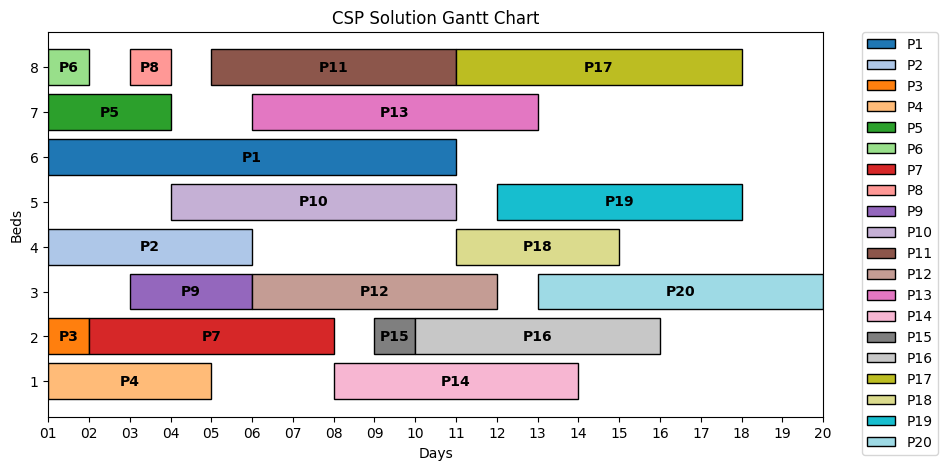

In [2]:
import time
from csp import *
from dataset_parser import dataset_parser
from graph import create_gantt_chart

#Importe and open the dataset
with open("dataset.txt", "r") as file:
    dataset = file.read()
    bed_rooms, room_departments, patients_data = dataset_parser(dataset)

#Variables
beds = [f'bed{i}' for i in range(1, 9)]
patients = [f'patient{i}' for i in range(1, len(patients_data) + 1)]
domains = {f'patient{i}': set(range(1, len(bed_rooms) + 1)) for i in range(1, len(patients_data) + 1)}

# Department
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if patients_data[p]['dept'] == 1 and room_info['dept'] == 2:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)
        elif patients_data[p]['dept'] == 2 and room_info['dept'] == 1:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)


## Telemetry
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
         if room_info['telemetry'] == 0 and patients_data[p]['telemetry'] == 1:
             matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
             for bed_number in matching_beds:
                 domains[f"patient{p}"].discard(bed_number)



# Oxygen
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if room_info['oxygen'] == 0 and patients_data[p]['oxygen'] == 1:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)
                


constraints = []

#Constraint_day
for p1 in range(1, len(patients) + 1):
    for p2 in range(1, len(patients) + 1):
        if p1 != p2 and not (patients_data[p1]['admission_day'] >= patients_data[p2]['discharge_day'] or patients_data[p2]['admission_day'] >= patients_data[p1]['discharge_day']):
            constraints.append(Constraint([f'patient{p1}', f'patient{p2}'], lambda a, b: a != b))


# Create CSP instance
csp = NaryCSP(domains, constraints)

# Find a solution using AC solvers
solution = ac_solver(csp, arc_heuristic=sat_up)
print(solution)

create_gantt_chart(solution, bed_rooms, patients_data)


## Our dataset

We created a new dataset 'our_dataset.txt' wich introduces several changes to the hospital setup compared to the first dataset:

1. **Departments:**
   - The second dataset includes an additional department, "Dept03," bringing the total number of departments to three.

2. **Rooms:**
   - The rooms are labeled differently, and there is an introduction of a room "R13" in department 1, "R23" in department 2, and a room "R31" in department 3.
   - Room capacities are adjusted, and new information such as the gender of the room is included.

3. **Beds:**
   - Additional beds are introduced, labeled differently and assigned to the new rooms.

4. **Patients:**
   - The patient dataset is modified with changes in admission and discharge days, medical requirements (Telemetry and Oxygen), and additional patients.
   - The gender of patients is now specified.
   - The "dept" field is removed.
   - New patients are added.

The 'real.py' is the code that runs this new dataset:

{'patient1': 6, 'patient2': 25, 'patient3': 20, 'patient4': 2, 'patient5': 22, 'patient6': 8, 'patient7': 9, 'patient8': 7, 'patient9': 10, 'patient10': 15, 'patient11': 3, 'patient12': 24, 'patient13': 18, 'patient14': 12, 'patient15': 19, 'patient16': 13, 'patient17': 11, 'patient18': 5, 'patient19': 17, 'patient20': 1, 'patient21': 23, 'patient22': 26, 'patient23': 20, 'patient24': 24, 'patient25': 14, 'patient26': 4, 'patient27': 11, 'patient28': 21, 'patient29': 27, 'patient30': 10, 'patient31': 2, 'patient32': 25, 'patient33': 6, 'patient34': 16, 'patient35': 8, 'patient36': 22, 'patient37': 7, 'patient38': 15, 'patient39': 5, 'patient40': 9, 'patient41': 26, 'patient42': 20, 'patient43': 11, 'patient44': 21, 'patient45': 22, 'patient46': 10, 'patient47': 25, 'patient48': 3, 'patient49': 1, 'patient50': 12, 'patient51': 6, 'patient52': 4, 'patient53': 7, 'patient54': 22, 'patient55': 5, 'patient56': 11, 'patient57': 18, 'patient58': 16, 'patient59': 13, 'patient60': 24, 'patient6

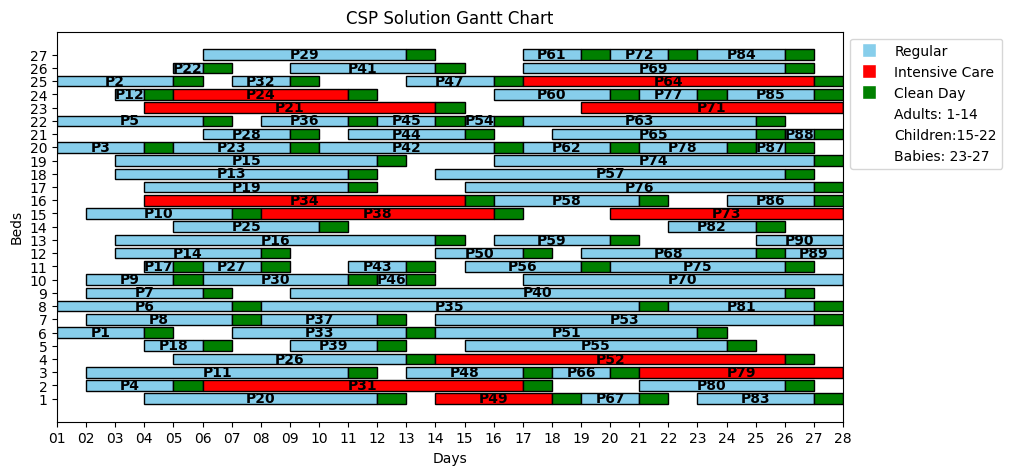

In [4]:
from csp import *
from our_dataset_parser import dataset_parser
from real_graph import create_gantt_chart

with open("our_dataset.txt", "r") as file:
    dataset = file.read()
    bed_rooms, room_departments, patients_data = dataset_parser(dataset)

#Variables
beds = [f'bed{i}' for i in range(1, len(bed_rooms))]
patients = [f'patient{i}' for i in range(1, len(patients_data) + 1)]
domains = {f'patient{i}': set(range(1, len(bed_rooms) + 1)) for i in range(1, len(patients_data) + 1)}

# Department
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if patients_data[p]['age'] <= 3 and room_info['dept'] != 3:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)
        elif 3 < patients_data[p]['age'] < 18  and room_info['dept'] != 2:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)
        elif patients_data[p]['age'] > 18  and room_info['dept'] != 1:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)

# Gender
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
        if patients_data[p]['gender'] != room_info['gender'] and patients_data[p]['age'] > 3:
            matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
            for bed_number in matching_beds:
                domains[f"patient{p}"].discard(bed_number)

## Intensive
for p in range(1, len(patients_data) + 1):
    for room_number, room_info in room_departments.items():
         if room_info['intensive_care'] == 0 and patients_data[p]['intensive_care'] == 1:
             matching_beds = [bed_number for bed_number, value in bed_rooms.items() if value == str(room_number)]
             for bed_number in matching_beds:
                 domains[f"patient{p}"].discard(bed_number)

constraints = []

#Constraint_day
for p1 in range(1, len(patients) + 1):
    for p2 in range(1, len(patients) + 1):
        if p1 != p2 and not (patients_data[p1]['admission_day'] > patients_data[p2]['discharge_day'] or patients_data[p2]['admission_day'] > patients_data[p1]['discharge_day']):
            constraints.append(Constraint([f'patient{p1}', f'patient{p2}'], lambda a, b: a != b))


# Create CSP instance
csp = NaryCSP(domains, constraints)

# Find a solution using AC solvers
solution = ac_solver(csp, arc_heuristic=sat_up)
print(solution)

if solution != False:
    create_gantt_chart(solution, bed_rooms, patients_data)

## Conclusion

In conclusion, the development of the intelligent agent for optimizing hospital bed management has been a significant endeavor, addressing the complex task of efficiently assigning beds to patients while considering departmental and room constraints. Throughout the project, various challenges were encountered and successfully overcome, leading to the creation of a robust solution.

The intelligent agent effectively leverages constraint satisfaction programming (CSP) principles to navigate the intricate web of dependencies between patients, beds, rooms, and departments. By incorporating domain-specific knowledge, such as patient medical requirements, the agent ensures not only optimal bed assignments but also adherence to critical healthcare protocols.

The design and implementation steps involved careful consideration of the hospital's structure, accommodating changes in the number of departments, rooms, and beds. The utilization of a CSP framework allowed for a flexible and scalable approach, making the agent adaptable to evolving hospital scenarios.

Documentation plays a pivotal role in this project, providing clarity on the agent's architecture, decision-making processes, and integration with hospital data. The documentation serves as a valuable resource for both understanding the agent's functionality and facilitating future enhancements or adaptations.

Looking ahead, the intelligent agent serves as a foundational tool for hospital administrators and healthcare professionals to enhance patient care by streamlining bed management. As healthcare systems evolve, the adaptability of the agent ensures its continued relevance and effectiveness in optimizing hospital resources.

This project not only addresses the immediate challenge of efficient bed assignment but also contributes to the broader field of intelligent systems in healthcare. The success of this endeavor underscores the potential for artificial intelligence to play a pivotal role in improving operational efficiency and patient outcomes within healthcare institutions.

## Repository 

https://github.com/a18851/IA_G09/

## References

https://saiconference.com/IntelliSys

http://aima.cs.berkeley.edu/

https://github.com/aimacode

